# Last Part: Model Training and Evaluation

In this notebook, we build a deep learning classifier that combines Convolutional Neural Networks (CNNs) and Long Short-Term Memory networks (LSTMs) to predict emotions from text. Our classifier will use the custom Word2Vec embeddings we generated earlier. The final output layer uses a softmax activation function, ensuring that the model outputs a probability distribution over the emotion classes.

Below, we break down each step with code and explanations.


## 1. Data Preparation

Firstly, we gotta go through what we did in the previous notebook, so here's a quick recap:

In [3]:
import pandas as pd
#process the data for training the model
data = pd.read_csv('./kaggle_data/training.csv', encoding='utf-8')
data = data.dropna()
data = data.drop_duplicates()
#take each sentence from the text column and store as text_data
text_data = data['text'].values

Next, we have to save the labels, which are classification labels with possible values including 

* sadness (0)
* joy (1)
* love (2)
* anger (3)
* fear (4)

In [5]:


#save labels. a classification label, with possible values including 
#sadness (0), joy (1), love (2), anger (3), fear (4).
labels = data['label'].values

total_count_per_label = {}
for label in labels:
    total_count_per_label[label] = total_count_per_label.get(label, 0) + 1

Ok, now we have the data and labels. Let's preprocess the data and start with the patterns. If we notice and check the kaggle_data, most of the text with contraction, the ' is ommited so we have to also include those. Let's first load the libraries, set the extension of is_sentiment, and add the dictionary of patterns as well as the sentiment lemmas that we need (in case if the stop word removal happens, we don't ommit the stop words that contain sentiment)

In [6]:
import re
from bs4 import BeautifulSoup
import spacy
from spacy.tokens import Token
Token.set_extension("is_sentiment", default=False, force=True)

patterns = {
    r"\bim\b": "I'm",
    r"\byoure\b": "you're",
    r"\bdidnt\b": "didn't",
    r"\bdont\b": "don't",
    r"\bcan't\b": "can't",  # Already correct if typed correctly, but you can handle "cant"
    r"\bcant\b": "can't",
    r"\bwont\b": "won't",
    r"\bwouldnt\b": "wouldn't",
    r"\bshouldnt\b": "shouldn't",
    r"\bcouldnt\b": "couldn't",
    r"\bmustnt\b": "mustn't",
    r"\bwasnt\b": "wasn't",
    r"\bwerent\b": "weren't",
    r"\bhavent\b": "haven't",
    r"\bhasnt\b": "hasn't",
    r"\bill\b": "I'll",
    r"\bhes\b": "he's",
    r"\bshes\b": "she's",
    r"\bits\b": "it's",      # Use context to decide if it's possessive or a contraction
    r"\bthats\b": "that's",
    r"\bwhos\b": "who's",
    r"\bhows\b": "how's",
    r"\bwheres\b": "where's",
    r"\btheres\b": "there's",
    r"\byoure\b": "you're",
    r"\bwouldve\b": "would've",
    r"\bshouldve\b": "should've",
    r"\bcouldve\b": "could've",
    r"\bmightve\b": "might've",
    r"\bmustve\b": "must've",
    r"\bneednt\b": "needn't",
    r"\bshant\b": "shan't",
    r"\byall\b": "y'all"
}
# Define a set of sentiment-bearing words (normalized to lowercase)
sentiment_lemmas = {"not", "no", "nor", "very", "extremely", "really", "so", "too", "just", "but"}

Ok great, now let's load our spacy model, create the `nlp` object, then create a list of tokenized texts where each sublist will be the text

In [7]:
nlp = spacy.load("en_core_web_sm")
tokenized_texts = []

Now let's go through each text in the text_data we extracted, then extract the text and remove extra whitespace and newlines. After that we will push the text through our processed pipeline package, mark tokens as sentiment-bearing based on their lemmas, after which we go through each token, and normalise and data cleanse each token (specifically if it's the words that we need for the sentiment analysis model)

In [8]:


for text in text_data:

    # Use BeautifulSoup to parse the text and remove unwanted tags
    soup = BeautifulSoup(text, "html.parser")
    for tag in soup(["script", "style"]):
        tag.decompose()  # Remove script and style elements completely

    # Extract text and remove extra whitespace/newlines
    text = soup.get_text(separator=" ")
    for pattern, replacement in patterns.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    text = re.sub(r'\s+', ' ', text)

    # Process the cleaned text with spaCy
    doc = nlp(text)

    # Mark tokens as sentiment-bearing based on their lemma
    for token in doc:
        if token.lemma_.lower() in sentiment_lemmas:
            token._.is_sentiment = True

    cleaned_tokens = []


    for token in doc:
        # Skip punctuation and numbers
        if token.is_punct or token.like_num:
            continue
        # Skip stop words UNLESS they are marked as sentiment-bearing.
        if token.is_stop and not token._.is_sentiment:
            continue
        lemma = token.lemma_.lower().strip()
        if lemma and lemma != '-pron-':
            cleaned_tokens.append(lemma)
    tokenized_texts.append(cleaned_tokens)
print(tokenized_texts[:5])

[['not', 'feel', 'humiliated'], ['feel', 'so', 'hopeless', 'so', 'damned', 'hopeful', 'just', 'care', 'awake'], ['grab', 'minute', 'post', 'feel', 'greedy', 'wrong'], ['feel', 'nostalgic', 'fireplace', 'know', 'property'], ['feel', 'grouchy']]


Ok, great. Now that we have the tokenized texts, let's introduce them to the model.

Before building the model, we need to convert our tokenized texts into padded sequences and prepare an embedding matrix using our pre-trained Word2Vec vectors.

In [9]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec

tokenized_texts is a list of lists (each inner list is the tokens for one document)
labels is a numpy array containing our class labels (e.g., 0 for sadness, 1 for joy, etc.)

### Firstly, we gotta convert token lists back to text (space-separated tokens) for Keras Tokenizer

### Then, we have to create and fit the tokenizer on the texts


In [10]:
texts = [" ".join(tokens) for tokens in tokenized_texts]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

### Great
now we have to determine the maximum sequence length. For example, 100 tokens. Along with that, we also need to determine the pad sequences accordingly, after which converting the labels to a numpy array since we've created a normal list of labels 

In [14]:
max_seq_length = 100
X = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

y = np.array(labels)
#Now, let's see the shape of the number_of_documents and max_seq_length
print("Shape of padded sequences:", X.shape)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

Shape of padded sequences: (15999, 100)


### Great stuff!! 🚀🚀🚀

What the previous part does is convert our cleaned text into sequences of integers where each integer represents a unique token. The padding ensure that all sequences have the same length for batch processing. Finally, the labels are just simply converted to a Numpy array for training. 

Our next step would be to to use a pretrained Word2Vec model so that our embedding layer is initialized. 

# Comparing Embedding Approaches: Custom vs. Google Pre-Trained

In this section we compare two scenarios for our emotion classifier:

1. **Scenario 1:** Using our custom Word2Vec embeddings (100 dimensions) trained on our dataset.
2. **Scenario 2:** Using the Google pre-trained Word2Vec embeddings (300 dimensions).

For both scenarios we follow the same pipeline:
- **Data Preparation:** Convert tokenized texts into padded sequences and build the corresponding embedding matrix.
- **Model Architecture:** Build a CNN-LSTM classifier with an embedding layer (initialized with our embedding matrix), a convolutional layer, an LSTM layer, and finally a dense output layer with a softmax activation.
- **Model Training and Evaluation:** Train the model and evaluate performance on a validation set.

---

## Scenario 1: Custom Word2Vec Embeddings (100 Dimensions)

### 1. Data Preparation & Building the Embedding Matrix

In [18]:
from gensim.models import Word2Vec
custom_w2v = Word2Vec.load("word2vec_custom.model")
embedding_dim = custom_w2v.vector_size

Now we build the embedding matrix for custom embeddings

In [19]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in custom_w2v.wv:
        embedding_matrix[i] = custom_w2v.wv[word]

print("Custom embedding matrix shape:", embedding_matrix.shape)

Custom embedding matrix shape: (11870, 100)


# 2. Model Architecture: Combining Convoluted Neural Networks with Long short-term Memory (type of RNN)

We will build a model that:

Uses an Embedding Layer (initialized with our custom embeddings).
Applies a 1D Convolutional Layer (CNN) to extract local features from the sequence.
Uses a MaxPooling Layer to reduce dimensionality.
Feeds the output into an LSTM Layer to capture sequential dependencies.
Concludes with a Dense Output Layer using a softmax activation function for multi-class classification.

### Recap: 
The softmax activation function converts a vector of raw scores (logits) into a probability distribution. For a given input vector **z** with components \( z_1, z_2, \dots, z_K \) for \( K \) classes, the softmax function is defined as:


```math
\sigma(z)_j = \frac{e^{z_j}}{\sum_{k=1}^{K} e^{z_k}}
```

- **Interpretation:**  
  - Each \( \sigma(z)_j \) represents the probability that the input belongs to class \( j \).
  - The outputs are in the range (0, 1) and sum to 1, making them interpretable as probabilities.


### How is it useful in our LSTM-based model?

In our emotion classification task, the final layer of our model is a dense (fully connected) layer with a softmax activation function. This is crucial because:
- It transforms the output of the network into a probability distribution over the five emotion classes.
- The class with the highest probability is chosen as the model's prediction.
- It enables the use of **cross-entropy loss** during training, which compares the predicted probabilities with the true labels to update the model weights.




Now let me familiarise you with the workflow:


### Step-by-Step Workflow of Our CNN-LSTM Model

1. **Input Preparation:**  
   - **Tokenization & Padding:**  
     Convert raw text into sequences of integer tokens. Then pad these sequences so that they have a uniform length, ensuring that the input data is suitable for batch processing.
  
2. **Embedding Layer:**  
   - **Purpose:**  
     Maps each token (an integer) to a dense vector representation (embedding).  
   - **Initialization:**  
     We initialize this layer with pre-trained embeddings (either our custom Word2Vec or Google’s pre-trained model).  
   - **Output:**  
     A 2D matrix representing the text, where each row corresponds to the embedding of a token.

3. **Convolutional Layer (CNN):**  
   - **Purpose:**  
     Applies 1D convolutions to capture local patterns (n-gram features) in the sequence.
   - **Mechanism:**  
     Filters slide over the embedding sequence to learn spatial features, which can be especially useful for detecting key phrases or word combinations that indicate emotions.

4. **MaxPooling Layer:**  
   - **Purpose:**  
     Reduces the dimensionality of the output from the CNN by selecting the maximum value from patches of the feature map, retaining the most important features.

5. **LSTM Layer (with Bidirectional Wrapper):**  
   - **Purpose:**  
     Captures the sequential and contextual dependencies in the text.  
   - **Bidirectionality:**  
     Processes the input in both forward and backward directions, which helps the network understand context from both ends of the sentence.

6. **Dense Layers:**  
   - **Purpose:**  
     Further process the features extracted by the CNN and LSTM layers.  
   - **Dropout:**  
     Regularization is applied to prevent overfitting.

7. **Output Layer with Softmax Activation:**  
   - **Purpose:**  
     Produces a probability distribution over the emotion classes.  
   - **Formula:**  
     Uses the softmax formula shown above to convert raw scores into class probabilities.
   - **Final Decision:**  
     The model predicts the emotion class with the highest probability.


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional

num_classes = len(np.unique(y))  # Number of emotion classes


### Embedding layer: Using our pre-trained embeddings, set trainable=False to keep them fixed
### Convlutional and LSTM layers
### Then we have the output layers

In [21]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=max_seq_length,
                    weights=[embedding_matrix],
                    trainable=False))

# Convolutional layer: Extract local features from the embeddings.
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM layer: Capture sequential information.
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))

# Dense layer: Further processing with dropout for regularization.
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer: Softmax activation outputs a probability distribution over classes.
model.add(Dense(num_classes, activation='softmax'))

model.summary()

/Users/daniyalkhaibullin/Documents/projects/sentiment_analysis/sent_env/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,187,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,187,000 (4.53 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,187,000 (4.53 MB)

Ok, great, the setup seems successful!🚀🚀🚀

# Model Training:

With our model defined, we compile and train it using our prepared data. We'll use the Adam optimizer and sparse categorical cross-entropy as our loss function since our labels are integers.

"
# Adam Optimizer

Adam (short for Adaptive Moment Estimation) optimizer combines the strengths of two well-known techniques—Momentum and RMSprop—to deliver a powerful method for adjusting the learning rates of parameters during training.

Adam is highly effective, especially when working with large datasets and complex models, because it is memory-efficient and adapts the learning rate dynamically for each parameter.

## How Does Adam Work?

Adam builds upon two key concepts in optimization:

### 1. Momentum

Momentum is used to accelerate the gradient descent process by incorporating an exponentially weighted moving average of past gradients. This helps smooth out the trajectory of the optimization, allowing the algorithm to converge faster by reducing oscillations.

The update rule with momentum is:

$$
w_{t+1} = w_t - \alpha \, m_t
$$

where:
- \( m_t \) is the moving average of the gradients at time \( t \),
- \( \alpha \) is the learning rate,
- \( w_t \) and \( w_{t+1} \) are the weights at time \( t \) and \( t+1 \), respectively.

The momentum term \( m_t \) is updated recursively as:

$$
m_t = \beta_1 \, m_{t-1} + (1-\beta_1) \, \frac{\partial L}{\partial w_t}
$$

where:
- \( \beta_1 \) is the momentum parameter (typically set to 0.9),
- \( \frac{\partial L}{\partial w_t} \) is the gradient of the loss function with respect to the weights at time \( t \). " - geeksforgeeks.org


In [23]:
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


Splitting the data into training and validation sets

In [24]:

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Finally compiling and training the model

In [25]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - accuracy: 0.3192 - loss: 1.6251 - val_accuracy: 0.3194 - val_loss: 1.5938
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.3398 - loss: 1.5886 - val_accuracy: 0.3359 - val_loss: 1.5859
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 24s 59ms/step - accuracy: 0.3515 - loss: 1.5769 - val_accuracy: 0.3509 - val_loss: 1.5737
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.3690 - loss: 1.5691 - val_accuracy: 0.3759 - val_loss: 1.5615
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - accuracy: 0.3663 - loss: 1.5585 - val_accuracy: 0.3731 - val_loss: 1.5509
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.3904 - loss: 1.5400 - val_accuracy: 0.3738 - val_loss: 1.5422
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.3972 - loss: 1.5213 - val_accuracy: 0.3891 - val_loss: 1.5232
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.4052 - loss: 1.5178 - 

Not the most promising, but let's see the evaluation

In [26]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4253 - loss: 1.4768
Validation Loss: 1.4933409690856934
Validation Accuracy: 0.41343748569488525


## Evaluating Our Model: Beyond Accuracy

Our current model achieves a validation accuracy of about **41.3%** and a loss of approximately **1.49**. While this tells us that the model is correctly classifying around 4 out of 10 instances, it doesn't give us the full picture of its performance.


### What Does This Mean?
- **Accuracy in Context:**  
  With 5 emotion classes (e.g., sadness, joy, love, anger, fear), random guessing would yield about 20% accuracy. Our model doing around 41% is better than random, but there's significant room for improvement.

- **Limitations of Accuracy:**  
  Accuracy alone doesn't show us how well the model handles each class, especially if the classes are imbalanced. It doesn't tell us if some classes are consistently misclassified.

### Deeper Evaluation with F1-Score and Confusion Matrix
- **F1-Score:**  
  The F1-score is the harmonic mean of precision and recall:
  
 ```math
  F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
```
  
  This metric helps us balance the trade-off between false positives and false negatives, offering a more nuanced view than accuracy alone.

- **Confusion Matrix:**  
  A confusion matrix shows how many instances of each class are correctly or incorrectly predicted. This is crucial to diagnose if certain emotions (classes) are being confused with one another.

### How Can We Improve the Accuracy?
1. **Data Augmentation:**  
   Increase the amount and diversity of training data to cover more language variations.
2. **Model Architecture Tuning:**  
   - Experiment with deeper or more complex networks (e.g., additional CNN layers, more LSTM units, or even attention mechanisms).
   - Adjust hyperparameters such as learning rate, dropout rates, or batch size.
3. **Embedding Strategy:**  
   - Consider fine-tuning the embedding layer by making it trainable.
   - Explore using alternative embeddings like Google’s 300-dimensional Word2Vec or even contextual embeddings (e.g., BERT) which might capture more nuanced language patterns.
4. **Evaluation Metrics:**  
   - Use metrics like the F1-score and confusion matrix to better understand class-wise performance.
   - Analyze misclassifications to see which emotions are most challenging and require further model tuning.

### Sample Code: Additional Evaluation Metrics
The following code computes and visualizes the confusion matrix and prints a classification report, giving us precision, recall, and F1-scores for each class.


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

           0       0.37      0.72      0.49       950
           1       0.47      0.60      0.53      1027
           2       0.67      0.01      0.03       303
           3       0.00      0.00      0.00       439
           4       0.27      0.04      0.07       375
           5       0.00      0.00      0.00       106

    accuracy                           0.41      3200
   macro avg       0.30      0.23      0.19      3200
weighted avg       0.36      0.41      0.33      3200



/Users/daniyalkhaibullin/Documents/projects/sentiment_analysis/sent_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/daniyalkhaibullin/Documents/projects/sentiment_analysis/sent_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/daniyalkhaibullin/Documents/projects/sentiment_analysis/sent_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samp

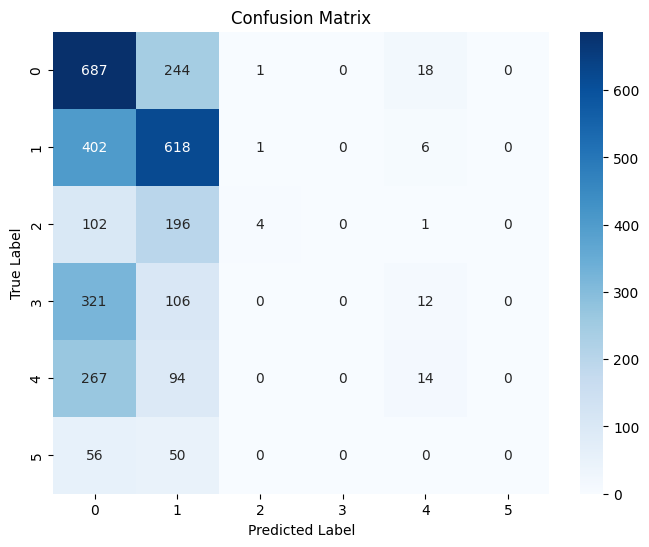

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = y_pred.argmax(axis=1)

# Print the classification report (includes precision, recall, F1-score)
print(classification_report(y_val, y_pred_classes))

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Plot the confusion matrix for a visual understanding
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

**Analysis:** The confusion matrix and classification report show that our model is heavily favoring certain classes (like labels 0 and 1) while almost completely ignoring others (such as 3, 4, and 5). Specifically, label 0 achieves a relatively high recall (72%) but low precision (37%), meaning the model often predicts 0 even when it's not correct. Labels 2, 3, 4, and 5 have very low recall (the model rarely predicts them correctly), indicating a significant imbalance in the predictions. Overall, the accuracy of 41% confirms that the model is doing better than random guessing for a 6-class problem, but the macro-average F1-score of 0.19 indicates that performance across all classes is uneven. To improve, we could fine-tune or unfreeze our embedding layer, collect or generate more balanced data (or apply class weighting/oversampling to address class imbalance), explore more complex architectures (e.g., adding attention mechanisms), and adjust hyperparameters (learning rate, number of LSTM units, dropout rates, etc.). Evaluating metrics like F1-score and confusion matrices is crucial for understanding these issues and guiding further optimization.


Below is a condensed example that incorporates potential improvements, such as making the embedding layer trainable, applying class weights, or adjusting hyperparameters. You can adapt these suggestions to suit your dataset and environment.


/Users/daniyalkhaibullin/Documents/projects/sentiment_analysis/sent_env/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     1,187,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,187,000 (4.53 MB)

 Trainable params: 1,187,000 (4.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.2080 - loss: 1.7952 - val_accuracy: 0.3684 - val_loss: 1.7597
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.3641 - loss: 1.5726 - val_accuracy: 0.6059 - val_loss: 0.9976
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.6463 - loss: 0.8381 - val_accuracy: 0.8681 - val_loss: 0.4429
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.8847 - loss: 0.3547 - val_accuracy: 0.8903 - val_loss: 0.3586
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9199 - loss: 0.2296 - val_accuracy: 0.8791 - val_loss: 0.4137
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.9450 - loss: 0.1545 - val_accuracy: 0.8947 - val_loss: 0.3585
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9562 - loss: 0.1184 - val_accuracy: 0.8869 - val_loss: 0.3988
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9635 - loss: 0.1027 - 

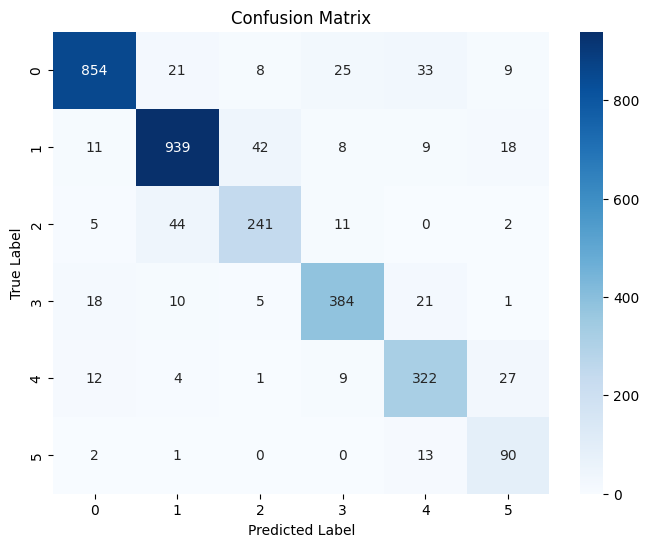

In [29]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Data Preparation ---
# Assume 'tokenized_texts' and 'labels' are already created.
texts = [" ".join(tokens) for tokens in tokenized_texts]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

max_seq_length = 100
X = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
y = np.array(labels)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

# --- 2. Load and Prepare Embeddings ---
custom_w2v = Word2Vec.load("word2vec_custom.model")
embedding_dim = custom_w2v.vector_size

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in custom_w2v.wv:
        embedding_matrix[i] = custom_w2v.wv[word]

# --- 3. Build the CNN-BiLSTM Model ---
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=max_seq_length,
                    weights=[embedding_matrix],
                    trainable=True))  # Make embedding trainable for fine-tuning

model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(np.unique(y)), activation='softmax'))

model.summary()

# --- 4. Split Data & Compute Class Weights (Optional) ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# If class imbalance is significant, compute class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

# --- 5. Compile & Train the Model ---
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    class_weight=class_weights_dict)  # Apply class weights if needed

# --- 6. Evaluate Model ---
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Generate predictions and evaluate with F1-score & confusion matrix
y_pred = model.predict(X_val).argmax(axis=1)
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

## MUCH BETTER!🚀🚀🚀